# LSTM modeling of TUH_SEZ EEG dataset

## Data Source

The TUH EEG Seizure Corpus (TUSZ): This corpus has manually EEG signals that have been carefully annotated data for seizures. For more information about this corpus, please refer to https://www.isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml

## Prerequisites 
* Download TUSZ dataset to your local machine, using the above link. This can be done using rsync, following the instruction in the download page. We need to register a username and password.
* pre-process the TUSZ dataset (Relavent notebooks in the directory)
2. insert the pre-processed data into a SQL database
3. host the SQL database via SQLengine. This can be localhost or remote on RDS, etc.


In [1]:
# !git clone https://github.com/ylin00/seizurecast
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seizurecast.postgresql import SQLengine
from seizurecast.models.parameters import LABEL_BKG, LABEL_PRE, LABEL_SEZ

def setlabel(pres, post, len_pos=300, len_pre=300, sec_gap=600):
  """convert pres and post timestamps to background and preseizure labels"""
  y = []
  for _, (pres, post) in enumerate(zip(pres, post)):
    if post > len_pos and pres > sec_gap + len_pre:
      y.append(LABEL_BKG)
    elif post > len_pos and pres > sec_gap:
      y.append(LABEL_PRE)
    else:
      y.append(LABEL_SEZ)
  return y

## Explore the table used in this notebook

### Preprocessed training set of TCP type 01 

In [310]:
pd.read_sql("select * from preprocessed_train_tcp01 where token='00010489_s005_t009' limit 1", SQLengine).head()


,index,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,token,timestamp,post,pres
0,0,3.075307,-1.437953,-0.510054,-1.787994,-9.574326,-1.176332,-8.338621,0.81589,00010489_s005_t009,0.0,99999.0,99999.0


## Patient directory

In [320]:
print("The count of distint patient\n",pd.read_sql("select count(distinct patient) from directory", SQLengine))
print("The head of table Directory")
pd.read_sql("select * from directory limit 10", SQLengine).head()

The count of distint patient
    count
0    637
The head of table Directory


,index,path0,path1,path2,path3,path4,path5,path6,train_test,tcp_type,patient_group,patient,session,token,token_path
0,0,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t008,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
1,1,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t009,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
2,2,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t001,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
3,3,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t000,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
4,4,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t002,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...


## Labels of seizure events from experts

In [321]:
[pd.read_sql(f"""
select * from seiz_bckg 
where label='{lbl}' and train_test='train'
""", SQLengine).to_sql(f'tmp_{lbl}_train', SQLengine, if_exists='replace') for lbl in ['bckg', 'seiz']]
print(f"""Number of token containing seizures = {pd.read_sql("select count(*) from tmp_seiz_train", SQLengine).to_numpy()[0,0]}""")
print(f"""Else = {pd.read_sql("select count(*) from tmp_bckg_train", SQLengine).to_numpy()[0,0]}""")
pd.read_sql("select * from tmp_seiz_train limit 3", SQLengine).head()

Number of token containing seizures = 2370
Else = 6967


,level_0,index,token,time_start,time_end,label,prob,train_test
0,0,36,00000492_s003_t000,6.2825,35.8875,seiz,1.0,train
1,1,39,00000492_s003_t001,33.1425,53.0000,seiz,1.0,train
2,2,42,00000492_s003_t002,9.7925,29.1250,seiz,1.0,train


# Split Train Test patients

In [325]:
# randomly sample 80/20 on patient level
from sklearn.model_selection import train_test_split
patient_id = np.unique(pd.read_sql("select * from directory where train_test='train' and tcp_type='01_tcp_ar'", SQLengine).loc[:,'patient'])
patient_train, patient_test = train_test_split(patient_id, test_size=0.2, random_state=0)

print(f"Patient ID: {patient_train[0:3]} ..., \n",
    f"Number of patients in Train:\t{patient_train.shape[0]}\n",
    f"Number of patients in Test:\t{patient_test.shape[0]}\n")

Patient ID: ['00000577' '00006103' '00007936'] ..., 
 Number of patients in Train:	246
 Number of patients in Test:	62



In [326]:
# Create table patient_group, storing patient ID and their train/test association
pd.concat([
    pd.DataFrame({'patient':patient_train}).assign(train_test='train'),
    pd.DataFrame({'patient':patient_test}).assign(train_test='test')
])
.to_sql('patient_group', SQLengine, if_exists='replace')

In [327]:
# create table tmp_token_group storing Token and their train/test group
pd.read_sql("""
select A.train_test, B.token
from patient_group A
inner join directory B on A.patient=B.patient;
""",SQLengine).to_sql('tmp_token_group', SQLengine, if_exists='replace')

In [330]:
print("Number of Tokens in each group \n", pd.read_sql("select * from tmp_token_group", SQLengine)[['train_test','token']].groupby('train_test').count())

Number of Tokens in each group 
             token
train_test       
test          712
train        2974


## Load train/test dataset

In [34]:
# Threshold
# len_pos, len_pre, sec_gap = 300, 300, 600  # default
len_pos, len_pre, sec_gap = 300, 600, 300

# select train dataset
feature_table = 'preprocessed_train_tcp01'
dataset=[]
for i, group in enumerate(['train', 'test']):
  dataset.append(pd.read_sql(f"""
  (
    select token, index, ch0, post, pres
    from {feature_table} A
    where A.token in (
      select B.token from tmp_token_group B where B.train_test='{group}'
    ) and (
      A.pres<{sec_gap + len_pre}
      and {sec_gap}<A.pres
      and A.post>{len_pos}
    ) 
    limit 10000000
  )

  union

  (
    select token, index, ch0, post, pres 
    from {feature_table} A
    where A.token in (
      select B.token from tmp_token_group B where B.train_test='{group}' 
    ) and (
      {sec_gap + len_pre}<A.pres
      and A.post>{len_pos}
    )
    limit 10000000
  );
  """, SQLengine))
print(f"Size of Tran set = {dataset[0].shape}; \nSize of Test set = {dataset[1].shape}")

Size of Tran set = (12022000, 5); 
Size of Test set = (10197107, 5)


In [35]:
import pickle
with open('datasets.pkl', 'wb') as f:
    pickle.dump(dataset, f)
# patient counts
dataset[0].groupby('token').count()

,index,ch0,post,pres
token,,,,
00005427_s008_t000,56406,56406,56406,56406
00005533_s003_t000,320512,320512,320512,320512
00005533_s005_t001,182016,182016,182016,182016
00005533_s006_t000,76800,76800,76800,76800
00005533_s006_t013,153856,153856,153856,153856
...,...,...,...,...
00012966_s009_t010,14,14,14,14
00012973_s006_t003,4896,4896,4896,4896
00013011_s001_t000,327936,327936,327936,327936


In [130]:
dataset[0].head()

,token,index,ch0,post,pres
0,00005427_s008_t000,0,-2.460638,99999.0,520.335938
1,00005427_s008_t000,1,-4.292062,99999.0,520.332031
2,00005427_s008_t000,2,-5.867857,99999.0,520.328125
3,00005427_s008_t000,3,-7.114939,99999.0,520.324219
4,00005427_s008_t000,4,-7.985012,99999.0,520.320312


In [69]:
print('binary clf data \n',
dataset[0]
    .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap))
    .loc[:,['label','ch0']]
    .groupby(['label'])
    .count())

binary clf data 
             ch0      post      pres
label                              
bckg   10000000  10000000  10000000
pres    2022000   2022000   2022000


# Training

## Data Prep

In [48]:
def chop_signal(long_vec, width=256, stepsize=64):
    """Chop a long long vector into 2D numpy array of width, consecutive rows will have certain overlap
    
    Args:
        long_vec: long vector
        width(int): width of the result. Must no greater than length of long_vec 
        overlap(int): Must less than width. 
    """
    long_vec = np.hstack([long_vec[i:i+width] for i in np.arange(0, len(long_vec)-width, stepsize)])
    return np.reshape(long_vec[0:(len(long_vec)//width*width)], [-1, width])

chop_signal([1, 2, 3, 4, 5, 6, 7, 8], width=4, stepsize=1)

array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6],
       [4, 5, 6, 7]])

In [49]:
def get_dataset(df, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap):
    df = df\
    .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap))\
    .loc[lambda df: 
         df.token.isin(
             df\
                .groupby('token')\
                .count()\
                .reset_index()\
                .loc[lambda df: df['index'] > 256]\
                .loc[:, ['token']].to_numpy().flatten()
         )]\
    .loc[:,['token', 'label', 'ch0']]\
    .groupby(['token', 'label'])\
    .apply(lambda df: pd.DataFrame(chop_signal(df['ch0'].to_numpy(), 256, 64)))\
    .reset_index()
    return df.iloc[:, 3:259], df.iloc[:, 1]

# dataset[0].pipe(get_dataset)[0].head()
# .loc[lambda df: df.groupby['token'].count().loc[:,'index']]

# .iloc[label=='pres'].head()

### Convert dataframe to numpy array

In [131]:
train_X, train_y = dataset[0].pipe(get_dataset)
test_X, test_y = dataset[1].pipe(get_dataset)

train_X, test_X = [x.to_numpy()[:, :, np.newaxis] for x in [train_X, test_X]]  # new feature axis
train_y, test_y = [x.to_numpy() for x in [train_y, test_y]]

# binarize
test_y = np.array([int(y==LABEL_PRE) for y in test_y])[:,np.newaxis]
train_y = np.array([int(y==LABEL_PRE) for y in train_y])[:,np.newaxis]

print(f'shape of train X = {train_X.shape}, test X = {test_X.shape}')

shape of train X = (187369, 256, 1), test X = (158974, 256, 1)


data contain a lot of spikes


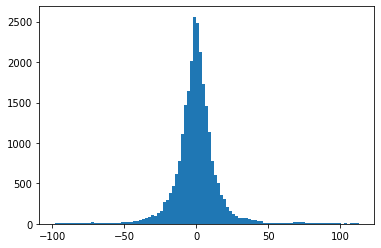

In [132]:
# sample some X to examine
nplot=min(100, train_X.shape[0])
np.random.seed(0)
choices = np.random.choice(train_X.shape[0], nplot, replace=False)

print("data contain a lot of spikes")
# np.histogram(train_X[1:1000,:].flatten())
# for features,label in train_ds.batch(1).take(10):
#   print(np.histogram(features.numpy().flatten()))
_ = plt.hist(train_X[choices,:].flatten(), bins = 101)

### Median Filter

Thrd = 200000


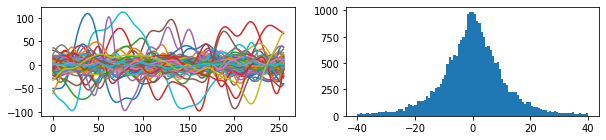

In [133]:
def get_median_filtered(signal, threshold=100):
    """By Bugra"""
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    # if over 10% of data are spikes. return zeros
    if type(mask) is not bool and np.sum(mask) > 0.1 * len(mask):
        return np.zeros(signal.shape)
    return signal

def median_filter(train_X, test_X, thrd):
    train_X = np.array([get_median_filtered(signal, thrd) for signal in train_X])
    test_X = np.array([get_median_filtered(signal, thrd) for signal in test_X])
    return train_X, test_X

def find_best_threshold():
    thrd = 200000
    newX = np.array([get_median_filtered(signal, thrd) for signal in train_X[choices,:]])
    print(f"Thrd = {thrd}")
    _, axs = plt.subplots(1,2,figsize=[10,2])
    for signal in newX:
        axs[0].plot(signal)
    _ = axs[1].hist(newX.flatten(), bins = 101, range=[-40,40])
    return thrd
    
thrd = find_best_threshold()

### Scaling

After removing spikes, the majority of the features are within a range of -20 to 20 (micro Vol). Let's scale them by 1/50 and normalize them.

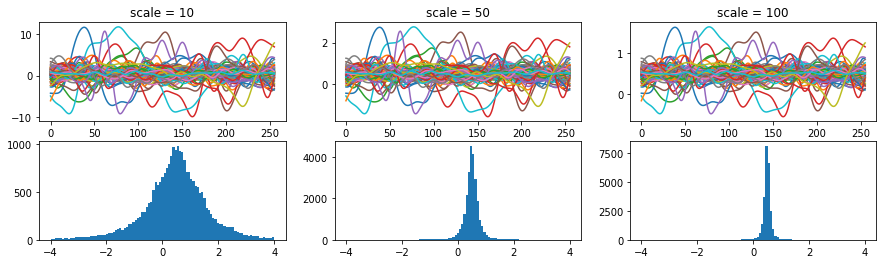

In [134]:
def normalize(train_X, test_X, scale):
    train_X = np.array([0.5 + (signal-np.mean(signal))/scale for signal in train_X ])
    test_X = np.array([0.5 + (signal-np.mean(signal))/scale for signal in test_X ])
    return train_X, test_X

def find_best_scale(train_X):
    _, axes = plt.subplots(2, 3, figsize=[15,4])
    for i, scale in enumerate([10, 50, 100]):
        ax = axes[0][i]
        tmp, _ = normalize(train_X, train_X, scale)
        for signal in tmp:
            ax.plot(signal)
            ax.title.set_text(f"scale = {scale}")
        axes[1][i].hist(tmp.flatten(), bins = 101, range=[-4,4])
find_best_scale(train_X[choices,:])

### Drop out weak channels 

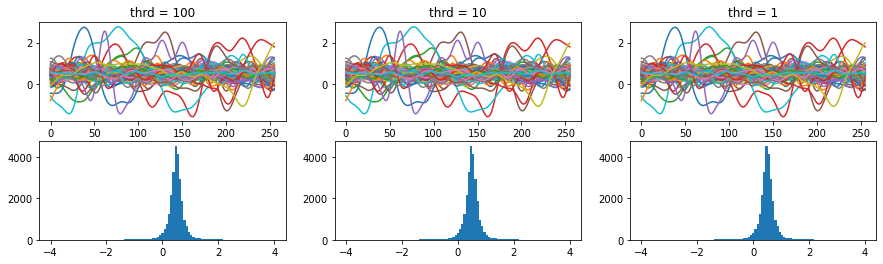

In [135]:
def dropout_weak_channels(train_X, train_y, threshold=1e-3):
    masks = [i for i, signal in enumerate(train_X) if np.sum(np.abs(signal))>threshold]
    train_X = train_X[masks, :, :]
    train_y = train_y[masks, :]
    return train_X, train_y

def find_best_threshold(train_X):
    _, axes = plt.subplots(2, 3, figsize=[15,4])
    for i, scale in enumerate([100, 10, 1]):
        ax = axes[0][i]
        tmp, _ = dropout_weak_channels(train_X, train_X[:,:,0], threshold=scale)
        for signal in tmp:
            ax.plot(signal)
            ax.title.set_text(f"thrd = {scale}")
        axes[1][i].hist(tmp.flatten(), bins = 101, range=[-4,4])


X, _ = median_filter(train_X[choices,:], train_X[choices,:], thrd=20000)
X, _ = normalize(X, X, scale=50)
X, _ = dropout_weak_channels(X, X[:,:,0], threshold=100)
find_best_threshold(X)

In [136]:
print("X shape = (samples, timesteps, nfeatures)")
print("y shape = (samples, nfeatures)")
print("")
print("Before processing")
print(f"shape trainX:{train_X.shape}")
print(f"shape trainy:{train_y.shape}")
print(f"shape testX:{test_X.shape}")
print(f"shape testy:{test_y.shape}")
train_X, test_X = median_filter(train_X, test_X, thrd=20000)
train_X, test_X = normalize(train_X, test_X, scale=100)
train_X, train_y = dropout_weak_channels(train_X, train_y, threshold=100)
test_X, test_y = dropout_weak_channels(test_X, test_y, threshold=100)
print("After processing")
print(f"shape trainX:{train_X.shape}")
print(f"shape trainy:{train_y.shape}")
print(f"shape testX:{test_X.shape}")
print(f"shape testy:{test_y.shape}")

X shape = (samples, timesteps, nfeatures)
y shape = (samples, nfeatures)

Before processing
shape trainX:(187369, 256, 1)
shape trainy:(187369, 1)
shape testX:(158974, 256, 1)
shape testy:(158974, 1)
After processing
shape trainX:(187369, 256, 1)
shape trainy:(187369, 1)
shape testX:(158974, 256, 1)
shape testy:(158974, 1)


In [137]:
# pd.DataFrame({
#     'train': pd.Series(train_y.squeeze()).value_counts(),
#     'test': pd.Series(test_y.squeeze()).value_counts()
# })

### Check data balance

In [138]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
def balance(train_X, train_y):
    np.random.seed(42)
    nchoices = np.random.choice(range(0, Counter(train_y.squeeze())[0]), Counter(train_y.squeeze())[1], replace=False)
    X1, X2 = train_X[train_y.squeeze()==0,:], train_X[train_y.squeeze()==1,:]
    train_X = np.concatenate([X1[nchoices, :], X2])
    train_y = np.concatenate([train_y[train_y.squeeze()==0][nchoices], train_y[train_y.squeeze()==1]])
    return train_X, train_y
X_res, y_res = balance(train_X, train_y)
print('Resampled dataset shape %s' % Counter(y_res.squeeze()))

Resampled dataset shape Counter({0: 31404, 1: 31404})


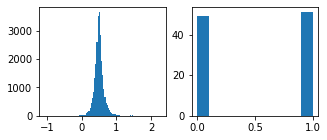

In [139]:
train_X, train_y = X_res, y_res
_, axes = plt.subplots(1, 2, figsize = [5,2])
_ = axes[0].hist(train_X[np.random.choice(range(0,len(train_X)),100), :].flatten(), bins=101)
_ = axes[1].hist(np.random.choice(train_y.squeeze(), 100).flatten())

## Modeling

In [140]:
# Shuffling dataset
def unison_shuffled_copies(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]
np.random.seed(0)
train_X, train_y = unison_shuffled_copies(train_X, train_y)
test_X, test_y = unison_shuffled_copies(test_X, test_y)

In [141]:
# import tensorflow as tf
# import matplotlib.pyplot as plt

# def pack_row(*row):
#   label = row[0]
#   features = tf.stack(row[1:],1)
#   return features, label

# # Packed dataset
# BATCHSIZE = 100
# train_ds = tf.data.Dataset.from_tensor_slices((train_X.squeeze(), train_y.squeeze())).batch(BATCHSIZE).map(pack_row).unbatch()
# test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCHSIZE).map(pack_row).unbatch()

# for features,label in train_ds.batch(100).take(1):
#   print(features[0])
#   plt.hist(label.numpy().flatten(), bins = 101)


Try Random Forest Classifier first

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from scipy.fft import fft
clf = RandomForestClassifier(max_depth=3, random_state=0)
cross_validate(
    clf, 
    np.array(
       [
           [
               np.mean(np.abs(fft(x))), 
               np.mean(np.abs(fft(x))*np.arange(0,len(x)))
           ] 
           for x in train_X.squeeze()
       ]
    ), 
    train_y.squeeze(), 
    cv=5
)

{'fit_time': array([3.05397916, 2.38703203, 2.60528469, 2.83010411, 2.16960716]),
 'score_time': array([0.09492183, 0.08564591, 0.09018707, 0.13794875, 0.08064914]),
 'test_score': array([0.59608343, 0.60428276, 0.59504856, 0.5920707 , 0.60265902])}

In [143]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

np.random.seed(0)

model = Sequential()

# model.add(Input(shape=(256,1), name='Input'))
# model.add(Dense(10, activation='relu', name='Dense-1'))

model.add(Bidirectional(LSTM(20, activation='relu', return_sequences=True, kernel_regularizer="l1", name='LSTM-1'), input_shape=(256,1)))
model.add(Dropout(0.25, name='Dropout-1'))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(10, activation='relu', return_sequences=False, kernel_regularizer="l1", name='LSTM-2')))
model.add(Dropout(0.25, name='Dropout-2'))
model.add(BatchNormalization())

model.add(Dense(1, activation='relu', kernel_regularizer='l1', name='Dense-3'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

print('start training')
model.fit(
        train_X, 
        train_y,
        validation_split=0.2, 
        batch_size=500, 
        epochs=1,
        verbose=1
    )

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 256, 40)           3520      
_________________________________________________________________
Dropout-1 (Dropout)          (None, 256, 40)           0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 40)           160       
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 20)                4080      
_________________________________________________________________
Dropout-2 (Dropout)          (None, 20)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20)                80        
_________________________________________________________________
Dense-3 (Dense)              (None, 1)               

/Users/yanxlin/opt/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


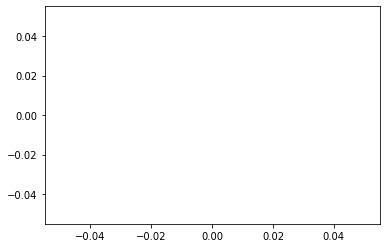

In [273]:
# Compare ROC curve
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, model.predict(test_X).ravel())

plt.plot(fpr_keras, tpr_keras)